<a href="https://colab.research.google.com/github/CsanyiDavid/deepdream/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
print(tf.__version__)

2.15.0


Plan
* clip to valid range during optimization
* create a wrapper class or function
* try inception model
* octave from tf tutorial

# First attempt



In [ ]:
def image_properites(img, text=''):
    print(text, type(img), img.shape, img.dtype, np.min(img), np.max(img))

 <class 'numpy.ndarray'> (224, 224, 3) float32 0.0 255.0


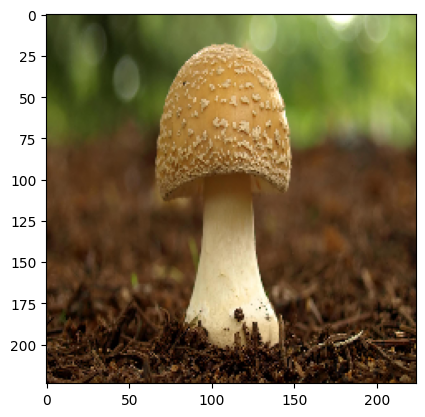

 <class 'numpy.ndarray'> (224, 224, 3) float32 0.0 255.0
<class 'numpy.ndarray'> (1, 224, 224, 3) float32 -123.68 151.061


In [ ]:
#Load and resize image
img_path = 'mushroom.jpg'
img = keras.utils.load_img(img_path, target_size=(224, 224))
x = keras.utils.img_to_array(img)
image_properites(x)

plt.imshow(x/255.)
plt.show()

image_properites(x)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg19.preprocess_input(x)

print(type(x), x.shape, x.dtype, np.min(x), np.max(x))

In [ ]:
vgg = keras.applications.VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

574710816/574710816 [==============================] - 10s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
output = vgg.predict(x)
print(np.max(output), np.argmax(output))
tf.keras.applications.vgg19.decode_predictions(
    output, top=1
)

1/1 [==============================] - 1s 1s/step
0.73197657 947
35363/35363 [==============================] - 0s 0us/step


[[('n07734744', 'mushroom', 0.73197657)]]

 <class 'numpy.ndarray'> (1, 224, 224, 3) int64 0 254


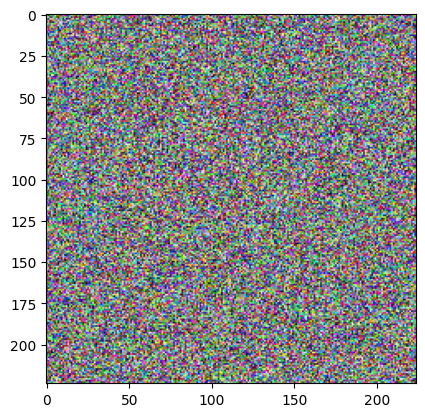

 <class 'numpy.ndarray'> (1, 224, 224, 3) float32 -123.68 150.061


In [ ]:
noise = np.random.randint(0, 255, size=(1, 224, 224, 3))
image_properites(noise)
plt.imshow(noise[0])
plt.show()

noise = keras.applications.vgg19.preprocess_input(noise)
image_properites(noise)

In [ ]:
output = vgg.predict(noise)
tf.keras.applications.vgg19.decode_predictions(
    output, top=1
)

1/1 [==============================] - 1s 1s/step


[[('n03598930', 'jigsaw_puzzle', 0.36208716)]]

In [ ]:
deepdream_model = keras.models.Model(
    inputs = [vgg.input],
    outputs = [vgg.output[:, 947]]
    #outputs = [vgg.output[:, 947],
    #           vgg.output[:, 497],
    #           vgg.output[:, 937]]
    #outputs = [vgg.get_layer('flatten').output[0]]
    #outputs = [vgg.get_layer('block5_conv4').output[..., 0:10]]

)

In [ ]:
def calculate_loss(image, model):
    output = model(image)
    if type(output) != list:
        output = [output]
    output = [tf.math.reduce_mean(i) for i in output]
    return -tf.reduce_mean(output)

In [ ]:
print(calculate_loss(noise, deepdream_model))
print(calculate_loss(x, deepdream_model))

tf.Tensor(-0.00039327264, shape=(), dtype=float32)
tf.Tensor(-0.73197657, shape=(), dtype=float32)


 <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'> (1, 224, 224, 3) <dtype: 'float32'> -123.68 151.061
 <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> 0.0 274.741
 <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> 0.0 1.0


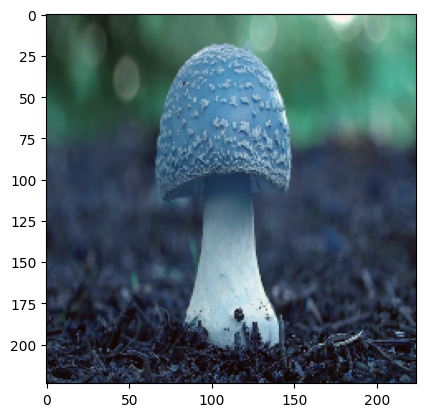

In [ ]:
input_image = tf.Variable(x)
image_properites(input_image)
processed_image = input_image-np.min(input_image)
image_properites(processed_image)
processed_image = processed_image/np.max(processed_image)
image_properites(processed_image)
plt.imshow(processed_image[0])
plt.show()

In [ ]:
steps = 20
learning_rate = 1
optimizer = tf.keras.optimizers.Adam(learning_rate)

for step in range(steps):
    print('iteration ', step)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        loss = calculate_loss(input_image, deepdream_model)
        grad = tape.gradient(loss, input_image)
        grad /= tf.math.reduce_max(grad) + 1e-8
        image_properites(grad, 'grad')
        optimizer.apply_gradients([(grad, input_image)])
        image_properites(input_image, 'input_image')
        print('\n')

iteration  0
grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> -1.2013328 0.99992627
input_image <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'> (1, 224, 224, 3) <dtype: 'float32'> -124.67994 152.06096


iteration  1
grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> -0.8899506 0.99942
input_image <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'> (1, 224, 224, 3) <dtype: 'float32'> -125.68117 153.05995


iteration  2
grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> -0.65853673 0.99487436
input_image <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'> (1, 224, 224, 3) <dtype: 'float32'> -126.66745 154.06169


iteration  3
grad <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> -1.1591182 0.9564741
input_image <class 'tensorflow.python.ops.resource_variab

 <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'> (1, 224, 224, 3) <dtype: 'float32'> -136.03021 163.30821
 <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> 0.0 299.33844
 <class 'tensorflow.python.framework.ops.EagerTensor'> (1, 224, 224, 3) <dtype: 'float32'> 0.0 1.0


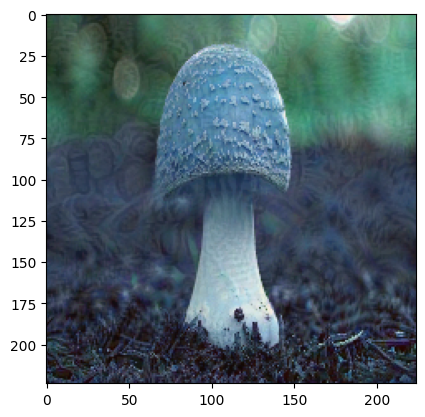

In [ ]:
image_properites(input_image)
processed_image = input_image-np.min(input_image)
image_properites(processed_image)
processed_image = processed_image/np.max(processed_image)
image_properites(processed_image)
plt.imshow(processed_image[0])
plt.show()

In [ ]:
output = vgg.predict(input_image)
print(np.max(output), np.argmax(output))
tf.keras.applications.vgg19.decode_predictions(
    output, top=1
)

1/1 [==============================] - 1s 953ms/step
0.9999999 947


[[('n07734744', 'mushroom', 0.9999999)]]